# Classification

In [36]:
#@title [Imports]
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

# Hadwritten Digit Classification

## Data Loading and Splitting

In [37]:
X,y = fetch_openml('mnist_784',version=1, return_X_y=True)
#return data in form of pandas dataframe

In [38]:
X=X.to_numpy()
y=y.to_numpy()

In [39]:
target_names =np.unique(y)
print('Number of samples:{0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features:{0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X),np.max(X)))
print('Number of classes:{0}, type:{1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples:70000, type:float64
Number of features:784
Minimum:0.0, Maximum:255.0
Number of classes:10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Preprocessing using MinMaxScaler to range it till 1

In [40]:
X=MinMaxScaler().fit_transform(X)
print('Minimum:{0}, Maximum:{1}'.format(np.min(X),np.max(X)))

Minimum:0.0, Maximum:1.0


## Data Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


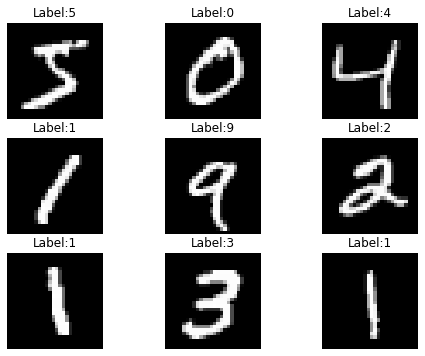

In [41]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

## Data Splitting

In [42]:
x_train, x_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Distribution of samples in each class

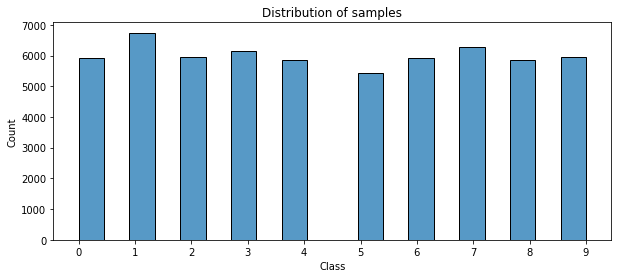

In [43]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

# Binary Classification : 0-Detector

## Modifying Labels

Label 0 to 1 and Label 1-9 changed to -1

In [44]:
#initialize new variables names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0')

y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

In [45]:
print(y_train)

['5' '0' '4' ... '5' '6' '8']


In [46]:
print(y_train_0)

[-1.  1. -1. ... -1. -1. -1.]


In [47]:
def visualize_data(X,y,num_images=9):
  num_images = 9 #choose a square number
  factor = np.int(np.sqrt(num_images))
  fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
  idx_offset = 0 #take "num_images" starting from the index "idx_offset"
  for i in range(factor):
    index = idx_offset+i*factor
    for j in range(factor):
      ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
      ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
      ax[i,j].set_axis_off()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


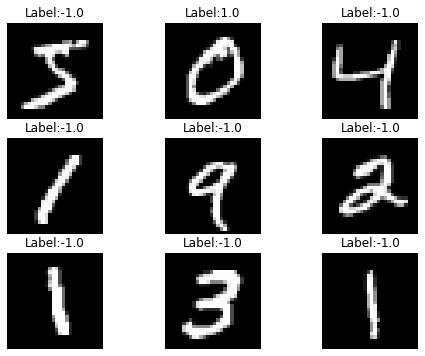

In [48]:

num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(x_train[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## Baseline Model

Follwoing rule:
1. Count number of samples per class
2. The model always input the class which had the highest number of samples
3. Then calculate the accuracy of the baseline model.

In [49]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==-1)[0])
print(num_pos,num_neg)

5923 54077


In [50]:
base_clf =DummyClassifier(strategy='most_frequent')

In [51]:
base_clf.fit(x_train,y_train_0)
print('Train accuracy:{0:.2f}'.format(base_clf.score(x_train,y_train_0)))
print('Testing accuracy:{0:.2f}'.format(base_clf.score(x_test,y_test_0)))

Train accuracy:0.90
Testing accuracy:0.90


## Perceptron Model

### Instantiation

In [52]:
bin_clf = Perceptron(max_iter=100,random_state=1729)

In [53]:
bin_clf.fit(x_train, y_train_0)
print('Dimension of weights w:{0}'.format(bin_clf.coef_.shape))
print('Bias :{0}'.format(bin_clf.intercept_))
print('the loss function: {0}'.format(bin_clf.loss_function_))

Dimension of weights w:(1, 784)
Bias :[-108.]
the loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7f6757691570>


In [54]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy:', bin_clf.score(x_train,y_train_0))

Training Accuracy: 0.99095


In [55]:
print('Test accuracy: ', bin_clf.score(x_test,y_test_0))

Test accuracy:  0.989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


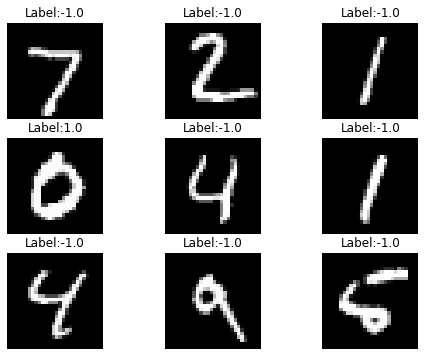

In [56]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [57]:
indx_0 = np.where(y_test_0==1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


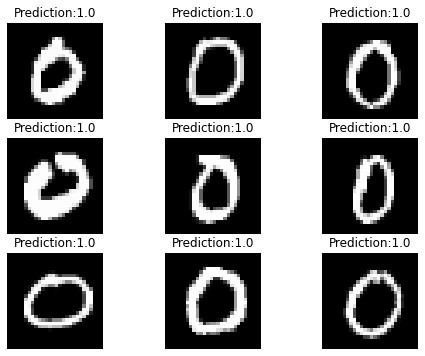

In [58]:
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

In [59]:
num_misclassified = np.count_nonzero(zeroLabls==-1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


## Better Evaluation Metrics

### Confusion Matrix

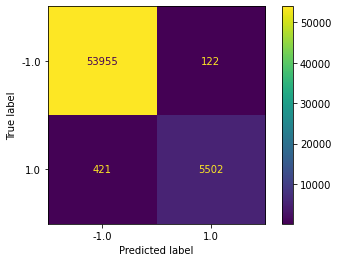

In [60]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()

### Precision and Recall

In [61]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [62]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tn+tp)/(tn+tp+fp+fn)
print('Precision: ',precision)
print('recall: ',recall)
print('accuracy: ',accuracy)

Precision:  0.9783072546230441
recall:  0.9289211548201924
accuracy:  0.99095


## Cross validations

In [63]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5,
                          scoring=['precision','recall','f1'],
                        return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.15803051, 2.21825957, 1.57145238, 1.37044811, 1.7259376 ]),
 'score_time': array([0.05377221, 0.04910183, 0.04227924, 0.04843855, 0.05804706]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [64]:
print('f1,      avg:{0:.2f},  std:{1:.3f}'.format(scores['test_f1'].mean(),scores['test_f1'].std()))
print('precision,      avg:{0:.2f},  std:{1:.3f}'.format(scores['test_precision'].mean(),scores['test_precision'].std()))
print('recall,      avg:{0:.2f},  std:{1:.3f}'.format(scores['test_recall'].mean(),scores['test_recall'].std()))

f1,      avg:0.94,  std:0.013
precision,      avg:0.96,  std:0.013
recall,      avg:0.92,  std:0.035


Pickup the first estimator return by the cross-validate function

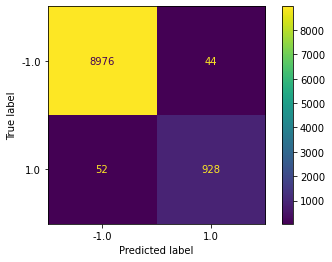

In [65]:
bin_clf_best = scores['estimator'][0]
y_hat_test_0 = bin_clf_best.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0, values_format='.5g')


In [66]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))

Precision 0.95
Recall 0.95


### Way-2 for Generalization

-  there is another approach of getting predicted labels via cross-validation and using it to measure the generalization
- In this case, each sample in the dataset will be part of only one test set in the splited folds

In [67]:
y_hat_train_0 = cross_val_predict(bin_clf,x_train, y_train_0,cv=5)


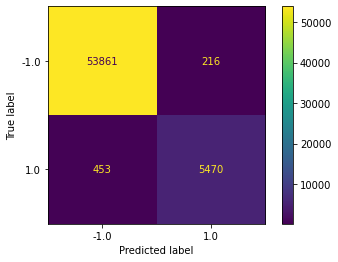

In [68]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

In [69]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]
print(fp)
print(fn)

216
453


In [70]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tn+tp)/(tn+tp+fp+fn)
print('Precision: ',precision)
print('recall: ',recall)
print('accuracy: ',accuracy)

Precision:  0.9620119591980303
recall:  0.9235184872530812
accuracy:  0.98885


In [71]:
print('Precision %.2f'%precision_score(y_train_0,y_hat_train_0))
print('Recall %.2f'%recall_score(y_train_0,y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0,y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Precision/ Recall Tradeoff

- It is important to note that we should not pass the **predicted labels** as input to `precision_recall_curve` function, instead we need to pass the probability score or the ouput from the decision function
- the Perceptron class contains the `decision_function` method, therefore we can make use of it.
- The internally the decision scores are sorted, tps and fps will be computed by changing the threshold form index[0] to index[-1]


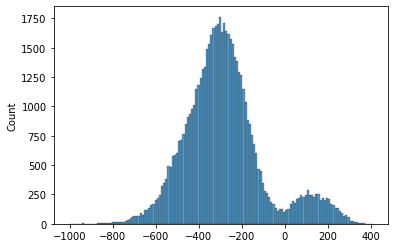

In [72]:
bin_clf= Perceptron(random_state=1729)
bin_clf.fit(x_train,y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

In [80]:
bin_clf.densify()

Perceptron(random_state=1729)

In [77]:
y_scores[40:50]

array([-551.31128028, -277.59581699, -381.71123414, -410.98408304,
       -467.84816609, -279.29542484, -197.45856209, -234.03800077,
       -277.56155325, -237.1671511 ])

In [81]:
x_train[40:800]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Many negative values than the positives ?
This is due to class imbalance
- Suppose threshold takes the value of -600, all the samples having scores greater than -600 is set to 1(positive label) and less than it is set to -1(neg label)
- Thereforem the number of False Positives will be increased. This will in turn reduce the precision score to a greater extent
-On the otherhand, if the threshold takes the value of, say, 400. Then the number of false negatives will increase and value of recall will reduce to a great extent.

In [83]:
precision, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

In [84]:
thresholds

array([-406.44696655, -406.44078431, -406.42795848, ...,  370.63932334,
        377.77657824,  411.888812  ])

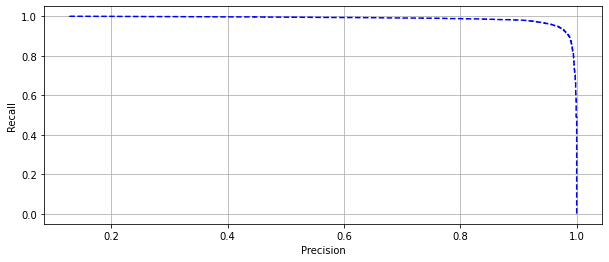

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(precision[:-1], recalls[:-1],"b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

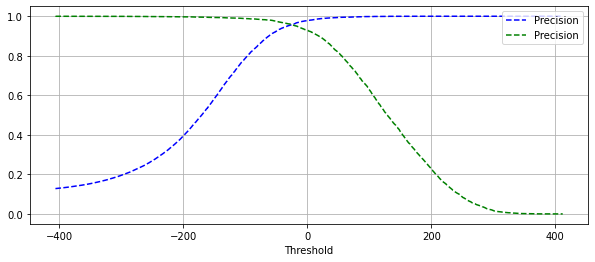

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precision[:-1], "b--",label="Precision")
plt.plot(thresholds,recalls[:-1],"g--",label="Precision")
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0,thresholds<1))
print('precision for zero thresholds: ',precision[idx_th[0][0]])

precision for zero thresholds:  0.9783072546230441


### The ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

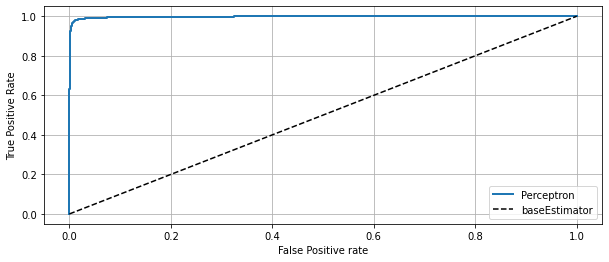

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr, linewidth=2,label='Perceptron')
plt.plot([0,1],[0,1],'k--',label='baseEstimator')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

## Warm Start vs Cold Start

### Cold Start
- If we execute the `fit` method repeatedly, we get same training and testing accuracy as they are initialized to the same values. This is called **cold start**


In [ ]:
bin_clf.fit(x_train,y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)
print('Training accuracy: ', bin_clf.score(x_train,y_train_0))
print('Testing accuracy: ', bin_clf.score(x_test, y_test_0))

Training accuracy:  0.99095
Testing accuracy:  0.989


### Warm Start

- Setting `warm_start=True` retains the weight values of the model after `max_iter` and hence produce different results for each execution.
- It helps us train the model by initiallizing the weight values fro the previous state, so we can pause the training and resu,e it whenever we get the resource for computation
- Not required for simple models like perceptron and for a small dataset like MNIST
- we use this feature in this notebook to plot the iteration vs loss curve

In [ ]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True
                          )

In [ ]:
bin_clf_warm.fit(x_train,y_train_0)
print('Training accuracy: ', bin_clf_warm.score(x_train,y_train_0))

Training accuracy:  0.99095


# Multiclass Classifier(One vsAll)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
clf = Perceptron(random_state=1729)


In [ ]:
#LabelBinarizer for encoding
y_train_ovr =LabelBinarizer().fit_transform(y_train) #setting sparse_output=True in LabelBinarizer() improves efficiency
for i in range(10):
  print('{0}:{1}'.format(y_train[i],y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


- The `y_train_ovr` will ow be having size of 60000x10

In [ ]:
clf.fit(x_train,y_train)

Perceptron(random_state=1729)

In [ ]:
print('Shape of Weight matrix:{0} and bias vector:{1}'.format(clf.coef_.shape,clf.intercept_.shape))

Shape of Weight matrix:(10, 784) and bias vector:(10,)


The class of perceptron that outputs the maximum score for the input sample is considered as the predicted class

In [ ]:
scores = clf.decision_function(x_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ', np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [ ]:
print('Predicted output:\n')
print(clf.predict(x_train[0].reshape(1,-1)))

Predicted output:

['5']


In [ ]:
#get the predictions for all training samples
y_hat = clf.predict(x_train)

In [ ]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



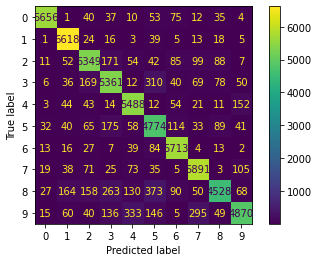

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_hat, values_format='.5g')


# Making a Pipeline

In [ ]:
estimators = [('std_scaler',MinMaxScaler()),('bin_clf',Perceptron())]
pipe = Pipeline(estimators)

In [ ]:
pipe.fit(x_train,y_train_0)

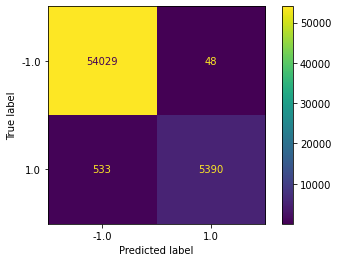

In [ ]:
y_hat_train_0 = pipe.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

# Iterations vs Loss Curve

In [ ]:
iterations =100
bin_clf1 = Perceptron(max_iter=1000,random_state=2094)
Loss_clf1=[]
for i in range(iterations):
  bin_clf1.partial_fit(x_train,y_train_0,classes=np.array([1,-1]))
  y_hat_0 = bin_clf1.decision_function(x_train)
  Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

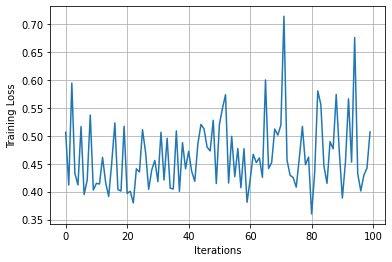

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss_clf1)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

#GridSearchCV

In [ ]:
scoring = make_scorer(hinge_loss,greater_is_better=False)
lr_grid =[1/2**n for n in range(1,6)]
bin_clf_gscv =GridSearchCV(Perceptron(),param_grid={"eta0":lr_grid},scoring=scoring,cv=5)
bin_clf_gscv.fit(x_train,y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [ ]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.48791723, 1.6077373 , 1.40869174, 1.02298088, 0.84579644]),
 'mean_score_time': array([0.03172688, 0.02791858, 0.02671056, 0.02314477, 0.01794224]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.

In [ ]:
iterations =100
best_bin_clf = Perceptron(max_iter=1000,random_state=2094,eta0=0.125)
Loss=[]
for i in range(iterations):
  best_bin_clf.partial_fit(x_train,y_train_0,classes=np.array([1,-1]))
  y_hat_0 = best_bin_clf.decision_function(x_train)
  Loss.append(hinge_loss(y_train_0, y_hat_0))

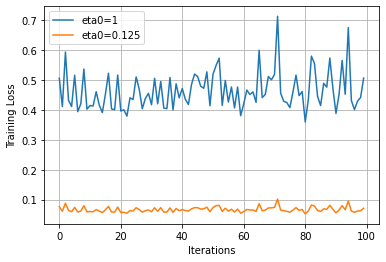

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss_clf1, label='eta0=1')
plt.plot(np.arange(iterations),Loss, label='eta0=0.125')
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
best_bin_clf=bin_clf_gscv.best_estimator_

In [ ]:
y_hat_train_0 =best_bin_clf.predict(x_train)
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99     54077
         1.0       0.95      0.95      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Visualizing Weight Vectors[Optional]

In [ ]:
bin_clf =Perceptron(max_iter=100)
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [ ]:
#find the index of false positive examples
idx_n =np.where(y_train_0==-1) #index of true -ve samples
idx_pred_p = np.where(y_hat_train_0==1) # index of prediceted positive samples
idx_pred_n =np.where(y_hat_train_0==-1) #index of predicted negative samples
idx_fp =np.intersect1d(idx_n,idx_pred_p)
idx_tn=np.intersect1d(idx_n,idx_pred_n)

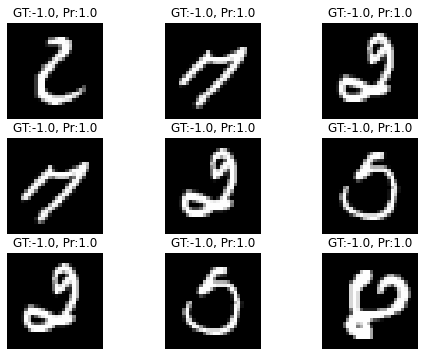

In [ ]:
fid,ax=plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(3):
  index=idx_offset+i
  for j in range(3):
    ax[i,j].imshow(x_train[idx_fp[index+j]].reshape(28,28),cmap='gray') #we should not use x_train with dummy
    ax[i,j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]), str(y_hat_train_0[idx_fp[index+j]])))
    ax[i,j].set_axis_off()

In [ ]:
from matplotlib.colors import Normalize

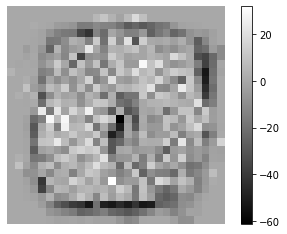

In [ ]:
w= bin_clf.coef_
w_matrix =w.reshape(28,28)
fig =plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

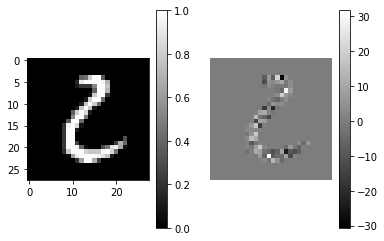

In [ ]:
activation =w*x_train[idx_fp[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_fp[0]].reshape(28,28),cmap='gray')
plt.colorbar()
#lin_out[lin_out<0]=0 just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
print(np.sum(lin_out)+bin_clf.intercept_)

[22.90520569]


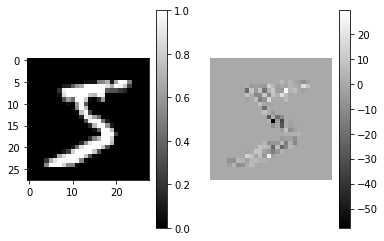

In [ ]:
activation =w*x_train[idx_tn[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_tn[0]].reshape(28,28),cmap='gray')
plt.colorbar()
#lin_out[lin_out<0]=0 just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
print(np.sum(lin_out)+bin_clf.intercept_)

[-293.33960784]
